<a href="https://colab.research.google.com/github/ihagoSantos/special-topics-in-machine-learning/blob/main/intro_openai_gym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

assert sys.version_info >= (3,7)

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [3]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

Verifique se existe uma GPU disponível

In [4]:
if not tf.config.list_physical_devices('GPU'):
  print('No GPU was detected. Neural nets cam be very slow without a GPU.')
  if "google.colab" in sys.modules:
    print("Go to Runtime > Change runtime and select a GPU hardware")
  if "kaggle_secrets" in sys.modules:
    print("Go to Settings > Acelerator and select GPU")

# Gymnasium

In [6]:
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
  %pip install -q -U gymnasium swig
  %pip install -q -U gymnasium[classic_control,box2d,atari,accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [7]:
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="rgb_array")

In [8]:
envs = gym.envs.registry

sorted(envs.keys())[:5] + ["..."]

['Acrobot-v1', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', '...']

O Cart-Pole é um ambiente muito simples composto por um carrinho que pode se mover para a esquerda ou para a direita, e um poste colocado verticalmente em cima dele.

In [9]:
envs["CartPole-v1"]

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

Vamos inicializar o ambiente chamando o método reset(). Isso retorna uma observação:

In [10]:
obs, info = env.reset(seed=42)


In [11]:
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

As observações variam de acordo com o ambiente. Nesse caso, é um array NumPy 1D composto por 4 números: a posição horizontal  do carrinho, sua velocidade, o ângulo do poste (0 = vertical) e a velocidade angular (se o poste está se movimentando para a direita ou para a esquerda)

In [12]:
info

{}

In [13]:
img = env.render()
img.shape # height, width, channels (3 = Red, Green, Blue)

(400, 600, 3)

In [14]:
def plot_environment(env, figsize=(5,4)):
  plt.figure(figsize=figsize)
  img = env.render()
  plt.imshow(img)
  plt.axis("off")
  return img

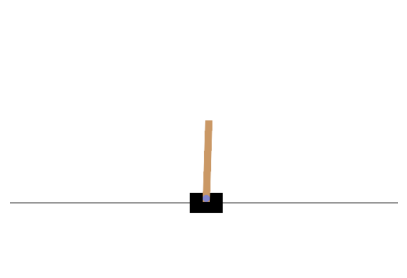

In [20]:
plot_environment(env)
plt.show()

## Interagindo com o ambiente
O agente precisará selecionar uma ação de um "espaço de ação". Vamos ver como é o espaço de ação deste ambiente:

In [21]:
env.action_space

Discrete(2)

Apenas duas ações possíveis: acelerar o carro para a esquerda ou para a direita.
Como o poste está inclinado para a direita (obs[2] > 0), vamos acelerar o carrinho para a direita:

In [22]:
action = 1 # accelerate right
obs, reward, done, truncated, info = env.step(action)

In [23]:
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

Observe que o carrinho agora está se movendo para a direita (obs[1] > 0). O poste ainda está inclinado para a direita (obs[2] > 0), mas sua velocidade angular agora é negativa (obs[3] < 0), então provavelmente será inclinado para a esquerda após a próxima etapa.

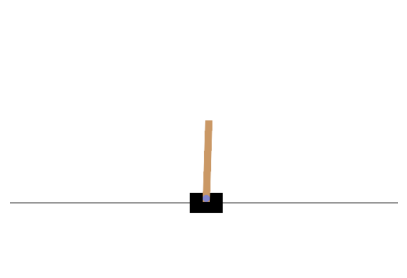

In [24]:
# extra code - displays the environment
plot_environment(env)
plt.show()

O ambiente também informa ao agente quanta recompensa ele recebeu durante a última etapa:


In [25]:
reward

1.0

Quando o jogo acaba, o ambiente retorna done=True

In [26]:
done

False

Alguns wrappers de ambiente podem querer interromper o ambiente antecipadamente. Por exemplo, quando o limite de tempo é atingido ou quando um objeto sai dos limites. Nesse caso, truncated será definido como True.


In [27]:
truncated

False

Info é um dicionário específico do ambiente que pode fornecer algumas informações extras que podem ser úteis para depuração ou treinamento. Por exemplo, em alguns jogos pode indicar quantas vidas o agente tem.

In [28]:
info

{}

A sequência de passos entre o momento em que o ambiente é reiniciado até que seja concluído é chamado de "episódio". No final de um episódio (ou seja, quando step() retorna done=True), você deve redefinir o ambiente antes de continuar a usá-lo

In [29]:
if done or truncated:
  obs, info = env.reset()

Agora, como podemos fazer o poste permanecer na posição vertical? Precisaremos definir uma política para isso. Essa é a estratégia que o agente usará para selecionar uma ação em cada etapa. Ela pode usar todas as ações e observações passadas para decidir o que fazer.

# Exemplo de uma policy

Uma estratégia simples: Se o poste estiver inclinado para a esquerda, empurre o carinho para a esquerda e vice-versa

In [30]:
def basic_policy(obs):
  angle = obs[2]
  return 0 if angle < 0 else 1

totals = []

for episode in range(500):
  episode_rewards = 0
  obs, info = env.reset(seed=episode)
  for step in range(200):
    action = basic_policy(obs)
    obs, reward, done, truncated, info = env.step(action)
    episode_rewards += reward
    if done or truncated:
      break

  totals.append(episode_rewards)


In [31]:
import numpy as np

np.mean(totals), np.std(totals), min(totals), max(totals)

(np.float64(41.698), np.float64(8.389445512070509), 24.0, 63.0)

Estratégia é um pouco básica: o melhor que ela fez foi manter o poste por apenas 63 passos. O cenário de vitória é quando o agente mantém o poste ativo por 200 passos. \\
Visualizando 1 episódio.

In [32]:
def update_scene(num, frames, patch):
  patch.set_data(frames[num])
  return patch

def plot_animation(frames, repeat=False, interval=40):
  fig = plt.figure()
  patch = plt.imshow(frames[0])
  plt.axis('off')
  anim = matplotlib.animation.FuncAnimation(
      fig, update_scene, fargs=(frames, patch),
      frames=len(frames), repeat=repeat, interval=interval
  )
  plt.close()
  return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
  frames=[]
  env = gym.make("CartPole-v1", render_mode="rgb_array")
  np.random.seed(seed)
  obs, info = env.reset(seed=seed)
  for step in range(n_max_steps):
    frames.append(env.render())
    action = policy(obs)
    obs, reward, done, truncated, info = env.step(action)
    if done or truncated:
      break

  env.close()
  return plot_animation(frames)

show_one_episode(basic_policy)